In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import necessary libraries
import os
import numpy as np
from PIL import Image, TiffImagePlugin
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import classification_report

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom dataset class for grayscale images
class GrayscaleImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load image paths and labels
        for label, subdir in enumerate(['nonflood', 'flood']):
            subdir_path = os.path.join(image_folder, subdir)
            for filename in os.listdir(subdir_path):
                filepath = os.path.join(subdir_path, filename)
                self.image_paths.append(filepath)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = np.array(Image.open(image_path).convert('L'))  # Load as grayscale
        image = np.stack([image] * 3, axis=-1)  # Convert to 3-channel format

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = GrayscaleImageDataset('/content/drive/MyDrive/dataset/train', transform=transform)
val_dataset = GrayscaleImageDataset('/content/drive/MyDrive/dataset/valid', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained Vision Transformer model with adjusted output size
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=2,
    ignore_mismatched_sizes=True
)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 4
model.train()
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).logits
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
val_targets = []
val_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)

        val_targets.extend(labels.cpu().numpy())
        val_predictions.extend(preds.cpu().numpy())

# Print classification report
print(classification_report(val_targets, val_predictions, target_names=['Non-flood', 'Flood']))

# Make predictions on a new image
def predict_image(image_path):
    model.eval()
    image = np.array(Image.open(image_path).convert('L'))  # Load as grayscale
    image = np.stack([image] * 3, axis=-1)  # Convert to 3-channel format
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image).logits
        _, pred = torch.max(output, 1)

    return 'Flood' if pred.item() == 1 else 'Non-flood'



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


UnidentifiedImageError: cannot identify image file '/content/drive/MyDrive/dataset/train/nonflood/3.tif'

In [18]:
# !pip install pillow_heif
# # Import necessary libraries
# import os
# import numpy as np
# from PIL import Image, TiffImagePlugin
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import transforms
# from torch.utils.data import DataLoader, Dataset
# from transformers import ViTForImageClassification, ViTFeatureExtractor
# from sklearn.metrics import classification_report

# # Set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Custom dataset class for grayscale images
# class GrayscaleImageDataset(Dataset):
#     def __init__(self, image_folder, transform=None):
#         self.image_folder = image_folder
#         self.transform = transform
#         self.image_paths = []
#         self.labels = []

#         # Load image paths and labels
#         for label, subdir in enumerate(['flood']):
#             subdir_path = os.path.join(image_folder, subdir)
#             for filename in os.listdir(subdir_path):
#                 filepath = os.path.join(subdir_path, filename)
#                 self.image_paths.append(filepath)
#                 self.labels.append(label)

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image_path = self.image_paths[idx]
#         # Handle potential errors when opening images
#         try:
#             image = np.array(Image.open(image_path).convert('L'))  # Load as grayscale
#         except Exception as e:
#             print(f"Error loading image {image_path}: {e}")
#             return None, None  # Return None for both image and label if error occurs

#         image = np.stack([image] * 3, axis=-1)  # Convert to 3-channel format

#         if self.transform:
#             image = self.transform(image)

#         label = self.labels[idx]
#         return image, label

# # Define transforms
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

# # Load datasets
# train_dataset = GrayscaleImageDataset('/content/drive/MyDrive/extra_ViT/train', transform=transform)
# val_dataset = GrayscaleImageDataset('/content/drive/MyDrive/extra_ViT/valid', transform=transform)

# # Filter out None values from dataset
# train_dataset = [(img, lbl) for img, lbl in train_dataset if img is not None]
# val_dataset = [(img, lbl) for img, lbl in val_dataset if img is not None]

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# # Load pre-trained Vision Transformer model with adjusted output size
# model = ViTForImageClassification.from_pretrained(
#     'google/vit-base-patch16-224',
#     num_labels=2,
#     ignore_mismatched_sizes=True
# )
# model.to(device)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

# # Training loop
# num_epochs = 10
# model.train()
# for epoch in range(num_epochs):
#     for images, labels in train_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = model(images).logits
#         loss = criterion(outputs, labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')





!pip install pillow_heif
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from transformers import ViTForImageClassification
from sklearn.metrics import classification_report

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom dataset class for grayscale images
class GrayscaleImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load image paths and labels
        for filename in os.listdir(image_folder):
            filepath = os.path.join(image_folder, filename)
            self.image_paths.append(filepath)
            # Assign label based on filename
            if "non_" in filename.lower():
                self.labels.append(0)  # non-flood
            else:
                self.labels.append(1)  # flood

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        # Handle potential errors when opening images
        try:
            image = np.array(Image.open(image_path).convert('L'))  # Load as grayscale
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None, None  # Return None for both image and label if error occurs

        image = np.stack([image] * 3, axis=-1)  # Convert to 3-channel format

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = GrayscaleImageDataset('/content/drive/MyDrive/extra_ViT/train', transform=transform)
val_dataset = GrayscaleImageDataset('/content/drive/MyDrive/extra_ViT/valid', transform=transform)

# Filter out None values from dataset
train_dataset = [(img, lbl) for img, lbl in train_dataset if img is not None]
val_dataset = [(img, lbl) for img, lbl in val_dataset if img is not None]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained Vision Transformer model with adjusted output size
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=2,
    ignore_mismatched_sizes=True
)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).logits
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Loss: 0.6606
Epoch [2/10], Loss: 0.0462
Epoch [3/10], Loss: 0.0087
Epoch [4/10], Loss: 0.0032
Epoch [5/10], Loss: 0.0016
Epoch [6/10], Loss: 0.0009
Epoch [7/10], Loss: 0.0006
Epoch [8/10], Loss: 0.0005
Epoch [9/10], Loss: 0.0003
Epoch [10/10], Loss: 0.0003


In [19]:
from sklearn.metrics import classification_report

# Evaluation
model.eval()
val_targets = []
val_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)

        val_targets.extend(labels.cpu().numpy())
        val_predictions.extend(preds.cpu().numpy())




In [20]:
# Print classification report
report = classification_report(val_targets, val_predictions, target_names=['Non-Flood', 'Flood'])
print(report)

              precision    recall  f1-score   support

   Non-Flood       1.00      1.00      1.00         3
       Flood       1.00      1.00      1.00         4

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



In [21]:
# Make predictions on a new image
def predict_image(image_path):
    model.eval()
    image = np.array(Image.open(image_path).convert('L'))  # Load as grayscale
    image = np.stack([image] * 3, axis=-1)  # Convert to 3-channel format
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image).logits
        _, pred = torch.max(output, 1)

    return 'Flood' if pred.item() == 1 else 'Non-flood'

In [7]:
# flood image
# non-flood image


# not a flood image, randome biolgical image from google, still o/p is flood only bcoz there is only 1 class: "flood"
# new_image_path = '/content/drive/MyDrive/extra_ViT/at3_1m4_01.tif'




The prediction for the new image is: Flood


The prediction for the new image is: Flood


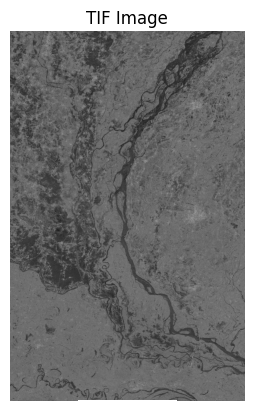

In [22]:
import matplotlib.pyplot as plt

new_image_path = '/content/drive/MyDrive/sample dataset/valid/masks/2.tif'

prediction = predict_image(new_image_path)
print(f'The prediction for the new image is: {prediction}')

image = Image.open(new_image_path)
image_array = np.array(image)

plt.imshow(image_array, cmap='gray')
plt.axis('off')
plt.title('TIF Image')
plt.show()

The prediction for the new image is: Non-Flood


The prediction for the new image is: Non-flood


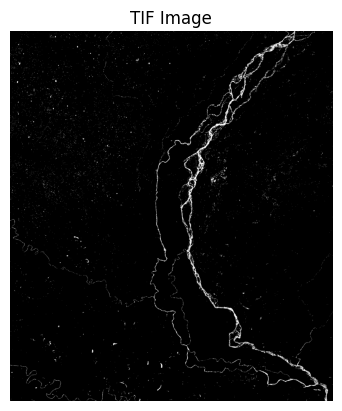

In [23]:
import matplotlib.pyplot as plt

new_image_path = '/content/drive/MyDrive/extra_ViT/valid/Copy of ViT_non_2020-04-21.tif'

prediction = predict_image(new_image_path)
print(f'The prediction for the new image is: {prediction}')

image = Image.open(new_image_path)
image_array = np.array(image)

plt.imshow(image_array, cmap='gray')
plt.axis('off')
plt.title('TIF Image')
plt.show()



The prediction for the new image is: Flood


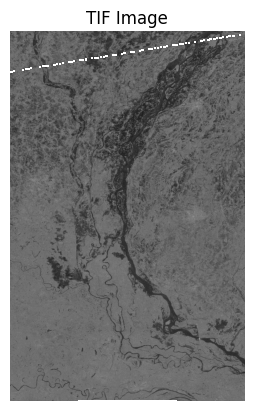

In [26]:

new_image_path = '/content/drive/MyDrive/dataset/train/flood/2.tif'

prediction = predict_image(new_image_path)
print(f'The prediction for the new image is: {prediction}')

image = Image.open(new_image_path)
image_array = np.array(image)

plt.imshow(image_array, cmap='gray')
plt.axis('off')
plt.title('TIF Image')
plt.show()


The prediction for the new image is: Non-flood


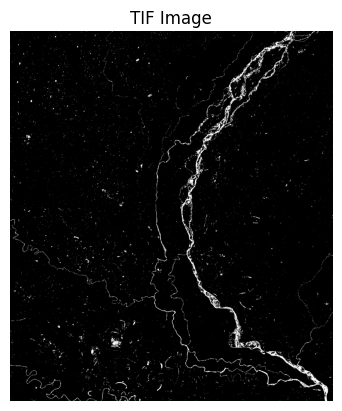

In [31]:

new_image_path = '/content/drive/MyDrive/ConvLSTM full/2021/2021-01-07.tif'

prediction = predict_image(new_image_path)
print(f'The prediction for the new image is: {prediction}')

image = Image.open(new_image_path)
image_array = np.array(image)

plt.imshow(image_array, cmap='gray')
plt.axis('off')
plt.title('TIF Image')
plt.show()


